<function matplotlib.pyplot.show>

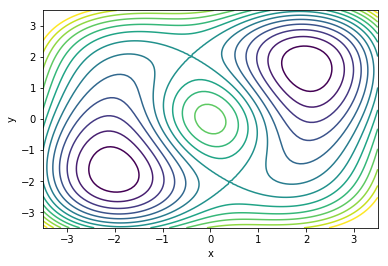

In [1]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

# TIS settings
n_moves = 500              # number of moves to perform for each path ensemble
op_type = 1                 # order parameter;  1:x  2:y  3:x+y
interfaces = [-1.5, -1.4, -1.3, -1.2, -0.8, -0.5, 0.0, 1.0, 2.0]
basinA = -1.78              # boundary of basin A; must be less than the first interface
basinB = interfaces[-1]     # basin B defined as last interface
init_coords = [-1, -1]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000          # basin equilibration length (steps)
basinlen = 50000           # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation

#Langevin dynamics settings
beta = 2.5     # 1/kT
gamma = 5.0    # friction
dt = 0.01      # time step size

#plot potential energy surface contours
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
X, Y = np.meshgrid(x_vec, y_vec)
energy = np.zeros((N, N))
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j])
plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
plt.xlabel('x')
plt.ylabel('y')
plt.show

Flux through first interface: 0.0688

Number of first crossings: 344

interface 0
Acceptance prob: 0.216000
interface 1
Acceptance prob: 0.176000
interface 2
Acceptance prob: 0.178000
interface 3
Acceptance prob: 0.212000
interface 4
Acceptance prob: 0.116000
interface 5
Acceptance prob: 0.090000
interface 6
Acceptance prob: 0.082000
interface 7
Acceptance prob: 0.038000
Crossing probabilities: [0.59, 0.682, 0.7463917525773196, 0.1465863453815261, 0.23318385650224216, 0.4168336673346693, 0.28484848484848485, 0.8742268041237113]
Rate: 7.331358814693442e-05


<function matplotlib.pyplot.show>

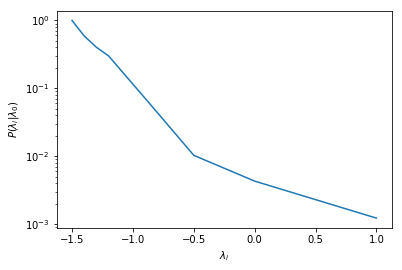

In [2]:
#declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)
#calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma)
#combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma)
#equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma)
    basintrajeq = new_basintrajeq
    op = ld.calc_op(op_type,basintrajeq[0],basintrajeq[1])
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

basintraj[0] = basintrajeq
fromBasin = False
n_cross = 0
#run basin A simulation and check for first crossings
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma)
    op = ld.calc_op(op_type,basintraj[j][0],basintraj[j][1])
    if op < basinA:
        fromBasin = True
    if fromBasin == True and op >= interfaces[0]:
        n_cross += 1
        fromBasin = False
    # check if trajectory reaches basin B
    if op >= basinB:
        sys.exit("Basin trajectory reached B! Exiting...")

if n_cross == 0:
    sys.exit("No first crossings obtained from basin A to interface 0. Exiting...")
flux = n_cross/(basinlen*dt)
print("Flux through first interface: {}\n".format(flux))
print("Number of first crossings: {}\n".format(n_cross))

#run at higher temperature to generate an initial path
initpath = []
beta_initpath = 1.5
fromBasin = False
#use init_phasepoint to start trajectory
trajstep = ld.vv_step(init_phasepoint,dt,beta_initpath,gamma)
op = ld.calc_op(op_type,trajstep[0],trajstep[1])
while op < basinB:
    nextstep = ld.vv_step(trajstep,dt,beta_initpath,gamma)
    trajstep = nextstep
    op = ld.calc_op(op_type,trajstep[0],trajstep[1])
    if op < basinA:
        fromBasin = True
        initpath = []       # reset path if it returns to A
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue
    if op >= basinA and fromBasin == True:
        trajstep = np.append(trajstep,[op],axis=0)
        initpath.append(trajstep)
        continue

initpath = np.asarray(initpath)

allpaths = []
cross_probs = []
for i in range(len(interfaces)-1):
    print("interface {}".format(i))
    intpaths = []
    n_cross = 0
    acc=0
    # Find the starting path for interface i
    last_frame = np.where(initpath[:,6] > interfaces[i+1])[0][0] + 1 
    path = initpath[:last_frame]
    # For each move
    for move in range(n_moves):
        reject_move = False
        lmax = round((len(path) + 1)/np.random.uniform())
        # Pick random shooting point
        index = np.random.randint(len(path) - 2) + 1 #minus 2 to avoid basinA and i+1 points
        # Perturb the momenta
        shoot_point = copy.deepcopy(path[index])
        shoot_point[2] += np.random.normal(0,sigma)
        shoot_point[3] += np.random.normal(0,sigma)
        trial_path = np.asarray([shoot_point])
        if exp(-beta*(ld.kinetic_energy(shoot_point) - ld.kinetic_energy(path[index]))) < np.random.uniform():
            reject_move = True
        # Integrate backwards path if we have not rejected the move...
        if reject_move == False:
            path_length = 1
            trial_path[:,2] *=-1
            trial_path[:,3] *=-1
            trajstep = copy.deepcopy(trial_path[-1])
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            while op >= basinA:
                trajstep = ld.vv_step(trajstep[:6],dt,beta,gamma)
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                trajstep = np.append(trajstep,[op],axis=0)
                trial_path = np.append(trial_path,[trajstep],axis=0)
                path_length +=1
                if path_length > lmax:
                    reject_move = True
                    break
                if op >= interfaces[i+1]:
                    reject_move = True
                    break
        if reject_move == False: 
            trial_path = np.flip(trial_path,axis=0)
            trial_path[:,2] *=-1
            trial_path[:,3] *=-1
            trajstep = copy.deepcopy(trial_path[-1])
            op = ld.calc_op(op_type,trajstep[0],trajstep[1])
            while op >= basinA and op < interfaces[i+1]:
                nextstep = ld.vv_step(trajstep[:6],dt,beta,gamma)
                trajstep = nextstep
                op = ld.calc_op(op_type,trajstep[0],trajstep[1])
                trajstep = np.append(trajstep,[op],axis=0)
                trial_path = np.append(trial_path,[trajstep],axis=0)
                path_length +=1
                if path_length > lmax:
                    reject_move = True
                    break

        # Final chance to reject a path (because no crossing interface i)
        if np.where(trial_path[:,6]>interfaces[i])[0].shape[0] == 0:
            reject_move = True
        # If we DON'T reject, then path becomes trial path
        if reject_move == False:
            path = trial_path
            acc+=1
        # Here we count the crosses
        if acc > 3:
            if np.where(path[:,6]>interfaces[i+1])[0].shape[0] > 0:
                n_cross +=1
            intpaths.append(path)

    allpaths.append(intpaths)
    cross_prob = n_cross/len(intpaths)
    cross_probs.append(cross_prob)
    print("Acceptance prob: %f" % (acc/n_moves))

rate = flux*np.prod(np.asarray(cross_probs))
print("Crossing probabilities: {}".format(cross_probs))
print("Rate: {}".format(rate))

#plot cumulative crossing probability
cumuprob = []
for i in range(len(cross_probs)):
    cumuprob.append(np.prod(np.asarray(cross_probs[:i])))
probs = plt.figure(2)
plt.plot(interfaces[:-1],cumuprob)
plt.yscale('log')
plt.xlabel('$\lambda_i$')
plt.ylabel('$P(\lambda_i|\lambda_0)$')
plt.show

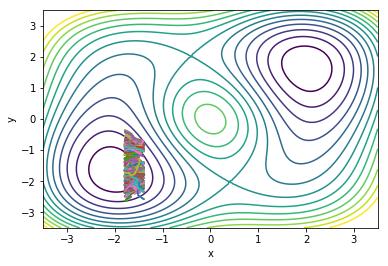

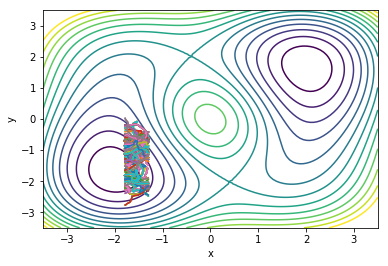

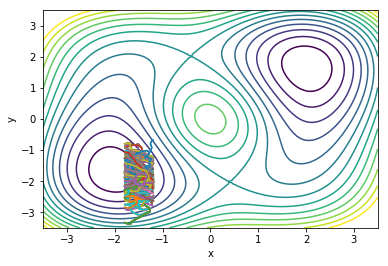

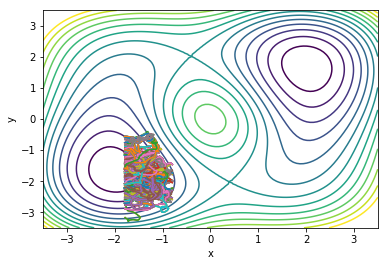

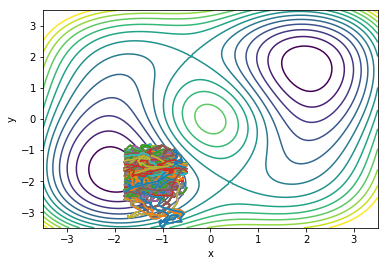

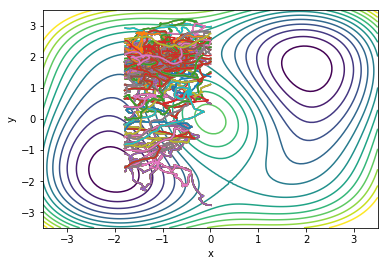

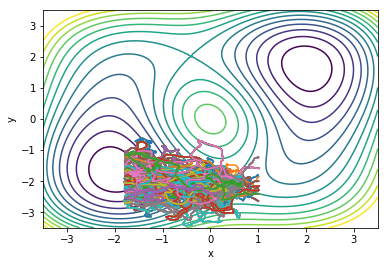

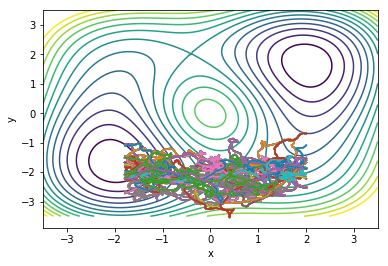

In [3]:
#plot sampled paths from each interface
for i in range(len(interfaces) - 1):
    plt.figure()
    for j in range(len(allpaths[i])):
        plt.plot(allpaths[i][j][:,0],allpaths[i][j][:,1])
    plt.contour(x_vec,y_vec,energy,[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show